In [14]:
import pandas as pd
import numpy as np
import data_handler as dh
#import model as md
import time
import matplotlib.pyplot as plt
from matplotlib import rc
import pickle

In [15]:
import importlib
importlib.reload(dh)
importlib.reload(md)

<module 'model' from '/Users/Dima/GAS/model.py'>

In [16]:
import numba
numba.__version__

'0.46.0'

In [17]:
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)
from platform import python_version
print('python', python_version())
print('numpy', np.__version__)
print('pandas', pd.__version__)
import graph_tool
print('graph_tool', graph_tool.__version__)

/Users/Dima/anaconda3/bin/python
3.7.5 (default, Oct 25 2019, 10:52:18) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
sys.version_info(major=3, minor=7, micro=5, releaselevel='final', serial=0)
python 3.7.5
numpy 1.17.4
pandas 0.25.2
graph_tool 2.29 (commit , )


In [18]:
import copy
import numpy as np
import transport_graph as tg

import oracles
import dual_func_calculator as dfc

#import universal_similar_triangles_method as ustm
#import universal_gradient_descent_method as ugd
#import subgradient_descent_method as sd
#import frank_wolfe_method as fwm
#import weighted_dual_averages_method as wda
#import accelerated_metaalgorithm_method as am

In [19]:
import numpy as np
from history import History

# Модель Бэкмана

In [20]:
beckmann_save = 'beckmann_results/'

net_name = 'Anaheim_net.tntp'
trips_name = 'Anaheim_trips.tntp'

mu = 0.25
rho = 0.15

handler = dh.DataHandler()
graph_data = handler.GetGraphData(net_name, columns = ['init_node', 'term_node', 'capacity', 'free_flow_time'])
graph_correspondences, total_od_flow = handler.GetGraphCorrespondences(trips_name)



table = graph_data['graph_table'].copy()
inits = np.unique(table['init_node'][table['init_node_thru'] == False])
terms = np.unique(table['term_node'][table['term_node_thru'] == False])
through_nodes = np.unique([table['init_node'][table['init_node_thru'] == True], 
                           table['term_node'][table['term_node_thru'] == True]])

nodes = np.concatenate((inits, through_nodes, terms))
nodes_inds = list(zip(nodes, np.arange(len(nodes))))
init_to_ind = dict(nodes_inds[ : len(inits) + len(through_nodes)])
term_to_ind = dict(nodes_inds[len(inits) : ])

table['init_node'] = table['init_node'].map(init_to_ind)
table['term_node'] = table['term_node'].map(term_to_ind)
correspondences = {}
for origin, dests in graph_correspondences.items():
    dests = copy.deepcopy(dests)
    correspondences[init_to_ind[origin]] = {'targets' : list(map(term_to_ind.get , dests['targets'])), 
                                                             'corrs' : dests['corrs']}
    
inds_to_nodes = dict(zip(range(len(nodes)), nodes))
graph_correspondences = correspondences
graph_table = table
graph = tg.TransportGraph(graph_table, len(inds_to_nodes), graph_data['links number'])    
    
    
phi_big_oracle = oracles.PhiBigOracle(graph, graph_correspondences)
h_oracle = oracles.HOracle(graph.freeflow_times, graph.capacities, 
                           rho = rho, mu = mu)
primal_dual_calculator = dfc.PrimalDualCalculator(phi_big_oracle, h_oracle,
                                graph.freeflow_times, graph.capacities,
                                rho = rho, mu = mu, base_flows = None)    

Начальные установки, объвление функций.

In [21]:
oracle = phi_big_oracle
prox = h_oracle.prox
primal_dual_oracle = primal_dual_calculator

x_start = graph.freeflow_times
L_init = graph.max_path_length**0.5 * total_od_flow
max_iter = 1000
eps = 1e-5
eps_abs = None
stop_crit = 'func_gap'
verbose_step = 100
verbose = False
save_history = True

Итерационный процесс.

In [22]:
tic = time.time()



if stop_crit == 'func_gap':
    def crit():
        F = oracle.func(x) + h_oracle.func(x)
        F_pred = oracle.func(x_pred) + h_oracle.func(x_pred)
        return np.abs(F - F_pred) < eps
else:
    raise ValueError("stop_crit should be 'func_gap'")

    
flows_start = primal_dual_oracle.get_flows(x_start) 
primal, dual, duality_gap_init, state_msg = primal_dual_oracle(flows_start, x_start)


lam = 1e-5
x_pred = np.copy(x_start)
x = np.copy(x_pred)
#L_value = np.linalg.norm(oracle.grad(x_start))
L_value = graph.max_path_length**0.5 * total_od_flow
A = 0.0


t_weighted = x
flows_weighted = primal_dual_oracle.get_flows(x)

#-------

if save_history:
    history = History('iter', 'primal_func', 'dual_func', 'dual_gap')
    history.update(0, primal, dual, duality_gap_init)
if verbose:
    print(state_msg)
if eps_abs is None:
    eps_abs = eps * duality_gap_init

#-------

success = False    


for it_counter in range(1, max_iter):
    
#    alpha = 1 / L_value
    alpha = 1/np.linalg.norm(oracle.grad(x))
    x_pred = np.copy(x)
    x = x_pred - lam * oracle.grad(x_pred) - lam * h_oracle.grad(x_pred)
    lam = lam/2
    
    
    F = oracle.func(x) + h_oracle.func(x)
    F_pred = oracle.func(x_pred) + h_oracle.func(x_pred)
    
#    if it_counter % 1 == 0:
#        print(f'iter: {it_counter}        t_min = {np.min(x): .6f}    t_max = {np.max(x): .6f}\t||x||={np.linalg.norm(x)}\tF = {np.abs(F - F_pred)}')
    
    flows = primal_dual_oracle.get_flows(x)
    
    A += alpha
    t_weighted = (t_weighted * (A - alpha) + x * alpha) / A
    flows_weighted = (flows_weighted * (A - alpha) + flows * alpha ) / A
    
#-------    

    primal, dual, duality_gap, state_msg = primal_dual_oracle(flows_weighted, t_weighted)
    if save_history:
        history.update(it_counter, primal, dual, duality_gap)
    if verbose and (it_counter % verbose_step == 0):
        print('\nIterations number: {:d}'.format(it_counter))
        print(state_msg, flush = True)
#-------
    if crit():
        success = True
        print('Konetz')
        break
        
flows = primal_dual_oracle.get_flows(x)
        
result = {'times': t_weighted, 'flows': flows_weighted,
          'iter_num': it_counter,
          'res_msg': 'success' if success else 'iterations number exceeded'}

#-------

if save_history:
    result['history'] = history.dict
if verbose:
    print('\nResult: ' + result['res_msg'])
    print('Total iters: ' + str(it_counter))
    print(state_msg)
    print('Oracle elapsed time: {:.0f} sec'.format(oracle.time))

#-------
    
    
    
toc = time.time()

Konetz


In [23]:
print('Elapsed time: {:.0f} sec'.format(toc - tic))
print('Time ratio =', np.max(result['times'] / graph_data['graph_table']['free_flow_time']))
print('Flow excess =', np.max(result['flows'] / graph_data['graph_table']['capacity']) - 1, end = '\n\n')

Elapsed time: 11 sec
Time ratio = 1.637338086451928
Flow excess = 1.339555555555553



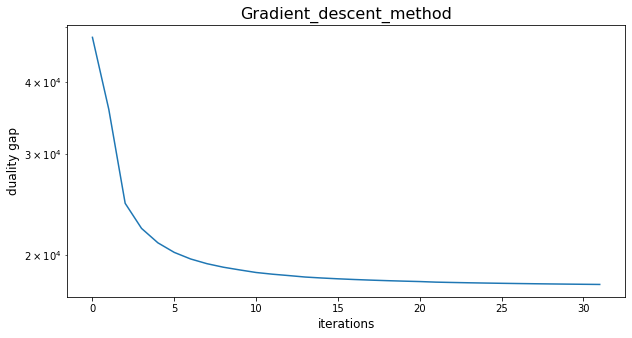

In [24]:
dual_gaps = np.array(result['history']['dual_gap'])
iters = np.array(result['history']['iter'])
plt.figure(figsize = (10, 5))
plt.plot(iters, dual_gaps)
plt.title('Gradient_descent_method', fontsize = 16)
plt.ylabel('duality gap', fontsize = 12)
plt.xlabel('iterations', fontsize = 12)
plt.yscale('log')
plt.show()